In [19]:
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
plt.style.use('fivethirtyeight')

SYMBOLS_LIST = ['PBF', 'PR', 'KOS', 'XOM', 'MRO', 'CVX', 'OXY', 'DK', 'SM', 'VTNR', 'WTI']
df = yf.download(SYMBOLS_LIST,  start = '2022-01-01')['Adj Close'].dropna(axis=0)
df

[*********************100%%**********************]  11 of 11 completed


,CVX,DK,KOS,MRO,OXY,PBF,PR,SM,VTNR,WTI,XOM
Date,,,,,,,,,,,
2022-01-03,110.761490,15.214392,3.82,16.393726,30.439814,13.682901,6.216777,30.987156,4.88,3.499707,59.097820
2022-01-04,112.776848,15.459481,4.02,17.112833,32.713490,13.907370,6.862551,33.425011,5.03,3.599413,61.320736
2022-01-05,113.510559,15.487760,3.95,16.724125,31.174839,13.721939,6.496291,32.328465,4.75,3.469795,62.083405
2022-01-06,114.476448,16.109911,4.27,17.520977,32.105869,15.029718,6.833636,33.718723,4.97,3.669208,63.543648
2022-01-07,116.120308,16.034498,4.33,17.725050,32.546886,15.908078,6.708337,32.073914,4.91,3.619355,64.064491
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-18,149.679993,27.110001,6.64,24.570000,58.970001,44.369999,13.440000,38.360001,3.64,3.250000,101.650002
2023-12-19,151.639999,27.030001,6.72,24.840000,60.299999,46.880001,13.350000,38.720001,3.46,3.270000,102.989998
2023-12-20,150.250000,26.440001,6.67,24.469999,60.169998,45.270000,13.200000,37.900002,3.53,3.210000,101.269997


In [16]:
def find_cointegrated_pairs(df, p_value_thresh):
    n = len(df.columns)
    pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            S1 = df.iloc[:,i]
            S2 = df.iloc[:,j]
            result = coint(S1, S2, trend = 'c', autolag = 'BIC')
            pvalue = round(result[1], 2)
            if pvalue <= p_value_thresh:
                pairs[f'{df.columns[i]} - {df.columns[j]}'] = pvalue
    return pairs

pairs = find_cointegrated_pairs(df=df, p_value_thresh = 0.05)

pairs

{'CVX - VTNR': 0.05,
 'DK - OXY': 0.02,
 'KOS - PBF': 0.02,
 'KOS - PR': 0.04,
 'KOS - SM': 0.05,
 'KOS - VTNR': 0.03,
 'KOS - WTI': 0.05,
 'MRO - VTNR': 0.04,
 'OXY - PBF': 0.05,
 'OXY - PR': 0.04,
 'OXY - SM': 0.02,
 'OXY - VTNR': 0.02,
 'OXY - WTI': 0.04}

In [49]:
stock_1 = 'OXY'
stock_2 = 'SM'

coint(df[stock_1], df[stock_2], trend = 'c', autolag = 'BIC')

(-3.645184888225732,
 0.021517648356928244,
 array([-3.91865672, -3.34847648, -3.05301186]))

In [50]:
selected_stocks_df = yf.download([stock_1, stock_2 ],  start = '2022-01-01').stack()

selected_stocks_df['return'] = (selected_stocks_df['Adj Close']-selected_stocks_df['Open'])/selected_stocks_df['Open']
selected_stocks_df['forward_return'] = selected_stocks_df.groupby(level = 1)['return'].transform(lambda x: x.shift(-1))
selected_stocks_df = selected_stocks_df[['Adj Close', 'forward_return']].unstack().droplevel(axis = 1, level = 0)
selected_stocks_df.columns = ['OXY', 'SM', 'OXY_forward_return', 'SM_forward_return']
selected_stocks_df[f'{stock_1}_return'] = np.log(selected_stocks_df[stock_1]).diff()
selected_stocks_df[f'{stock_2}_return'] = np.log(selected_stocks_df[stock_2]).diff()
selected_stocks_df = selected_stocks_df.dropna()
selected_stocks_df['hedge_ratio'] = RollingOLS(selected_stocks_df[f'{stock_1}_return'],
                                        selected_stocks_df[f'{stock_2}_return'],
                                        window = 180).fit().params.values
selected_stocks_df['spread'] = (selected_stocks_df[stock_1]-selected_stocks_df[stock_2]*selected_stocks_df['hedge_ratio'])

selected_stocks_df

[*********************100%%**********************]  2 of 2 completed


,OXY,SM,OXY_forward_return,SM_forward_return,OXY_return,SM_return,hedge_ratio,spread
Date,,,,,,,,
2022-01-04,32.713497,33.425007,-0.060716,-0.076329,0.072036,0.075731,NaN,NaN
2022-01-05,31.174841,32.328468,-0.033829,-0.017233,-0.048176,-0.033356,NaN,NaN
2022-01-06,32.105869,33.718727,-0.014626,-0.068702,0.029427,0.042105,NaN,NaN
2022-01-07,32.546886,32.073910,-0.040996,-0.052765,0.013643,-0.050010,NaN,NaN
2022-01-10,31.733456,31.182972,0.029895,0.045202,-0.025310,-0.028171,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-15,58.560001,37.880001,-0.012062,-0.015400,-0.003409,0.010883,0.419461,42.670801
2023-12-18,58.970001,38.360001,0.019959,0.013613,0.006977,0.012592,0.419646,42.872377
2023-12-19,60.299999,38.720001,-0.005619,-0.028454,0.022303,0.009341,0.417714,44.126104


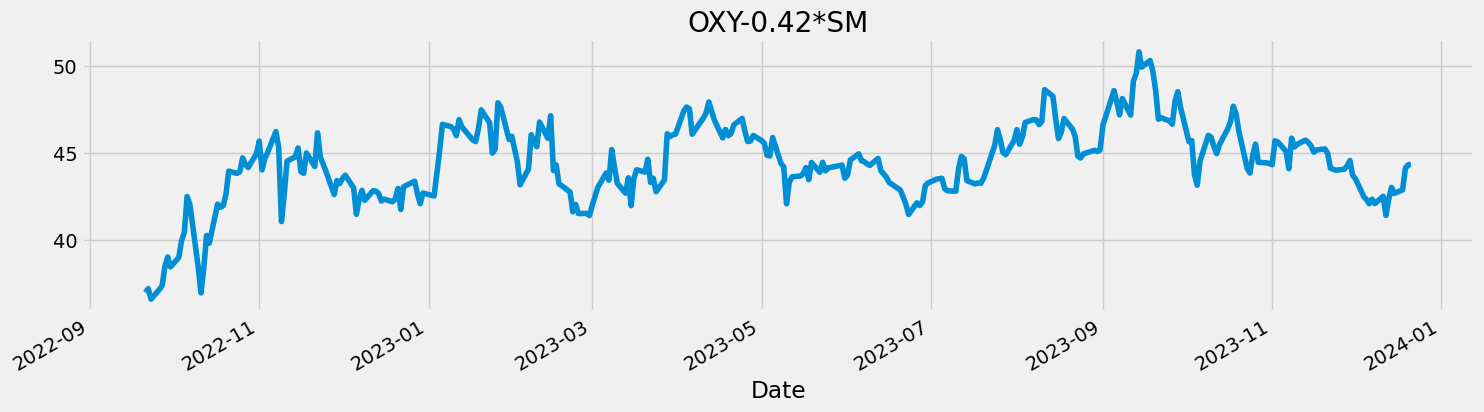

In [51]:
selected_stocks_df['spread'].plot(figsize=(16,4))
plt.title(f'{stock_1}-{round(selected_stocks_df.hedge_ratio[-1],2)}*{stock_2}')
plt.show()

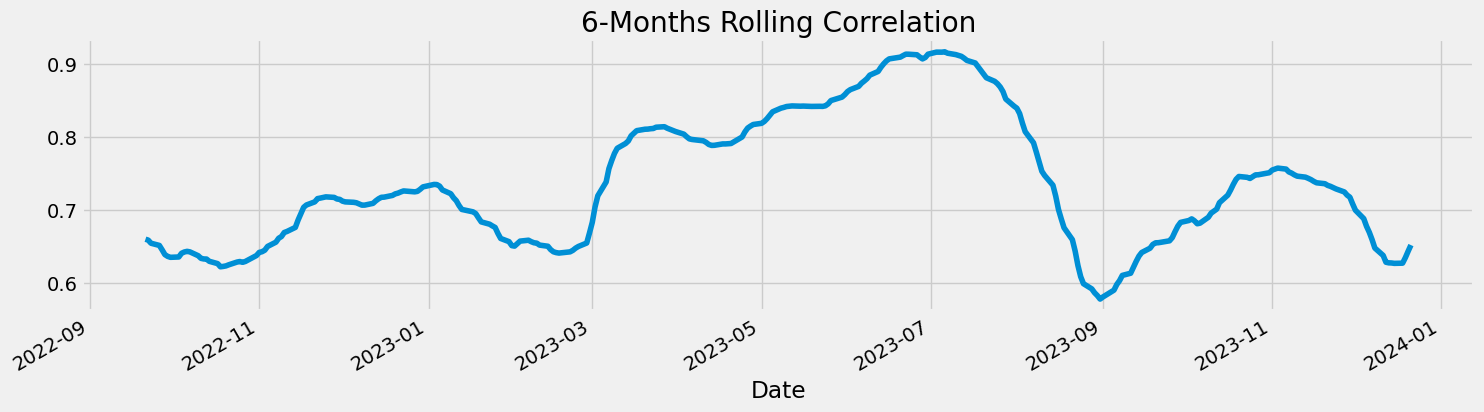

In [52]:
selected_stocks_df['roll_corr'] = selected_stocks_df['OXY'].rolling(180).corr(selected_stocks_df['SM'])

selected_stocks_df['roll_corr'].plot(figsize = (16,4))

plt.title('6-Months Rolling Correlation')

plt.show()

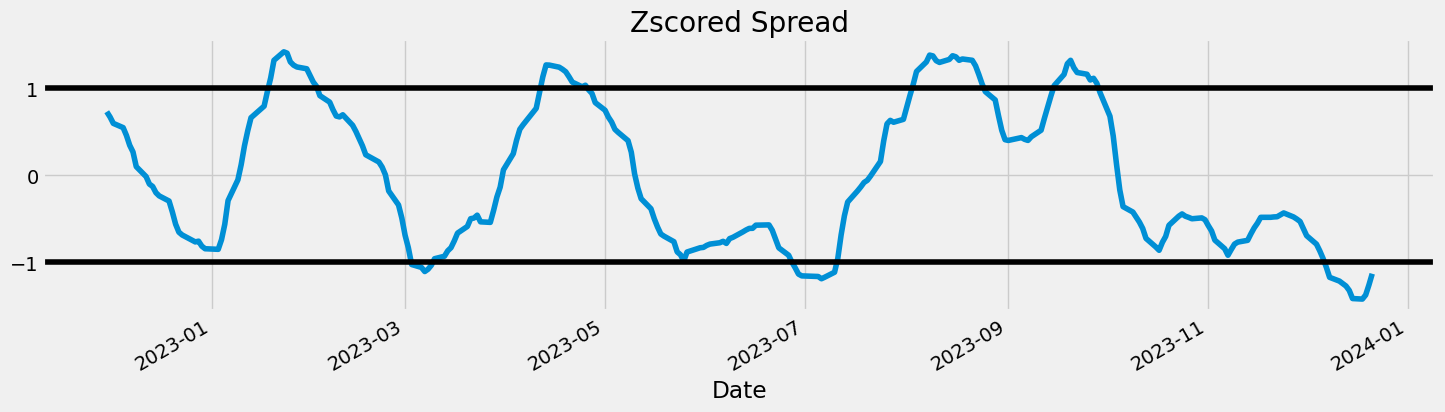

In [53]:
def smooth_zscore(spread):
    return(spread.rolling(12).mean()-spread.rolling(50).mean())/spread.rolling(50).std()

selected_stocks_df['zscored'] = smooth_zscore(selected_stocks_df['spread'])

selected_stocks_df['zscored'].plot(figsize=(16,4))

plt.title('Zscored Spread')

plt.axhline(1, color='k')

plt.axhline(-1, color='k')

plt.show()

In [54]:
selected_stocks_df['signal'] = selected_stocks_df.apply(lambda x: 1 if (x['zscored']<-1)
                                                       else (-1 if (x['zscored']>1) else np.nan), axis=1)

selected_stocks_df['strategy_return'] = selected_stocks_df[f'{stock_1}_forward_return']*selected_stocks_df['signal'] +\
selected_stocks_df[f'{stock_2}_forward_return']*selected_stocks_df['signal']*-selected_stocks_df['hedge_ratio']

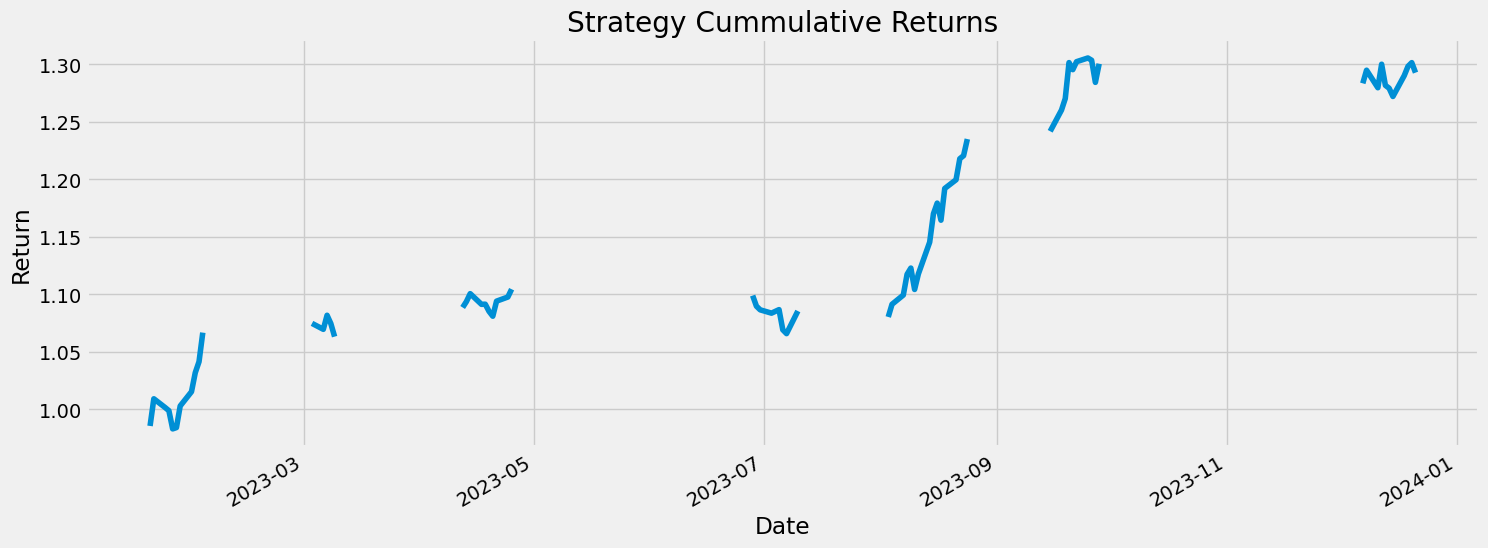

In [55]:
portfolios_cummulative_returns = np.exp(np.log1p(selected_stocks_df['strategy_return']).cumsum())

portfolios_cummulative_returns.plot(figsize=(16,6))

plt.title('Strategy Cummulative Returns')

plt.ylabel('Return')

plt.show()